In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('GE.csv',index_col='Date',parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-29,72.615143,74.137390,72.615143,73.887589,73.568665,11009426
2022-03-30,73.083527,74.270103,72.833725,73.832947,73.514252,7216642
2022-03-31,73.185013,73.341141,71.405151,71.428574,71.120262,10537122
2022-04-01,71.896957,72.256050,71.124123,72.201408,71.889755,7226505
2022-04-04,71.959404,72.068695,70.960190,71.834503,71.524437,6583828


In [3]:
cols = list(df)[0:1]

In [4]:
cols

['Open']

In [5]:
df1 = df[cols]

In [6]:
df1.head()

,Open
Date,
2022-03-29,72.615143
2022-03-30,73.083527
2022-03-31,73.185013
2022-04-01,71.896957
2022-04-04,71.959404


In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:xlabel='Date'>

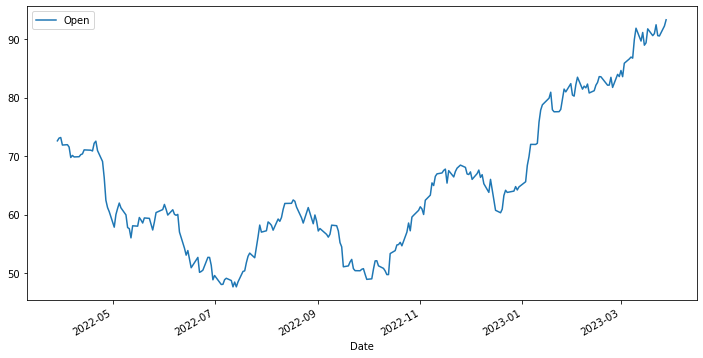

In [8]:
df1.plot(figsize=(12,6))

In [9]:
len(df1)

251

In [10]:
df1.shape

(251, 1)

In [11]:
train = df1.iloc[:210]
test = df1.iloc[210:]

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
df1.head(),df1.tail()

(                 Open
 Date                 
 2022-03-29  72.615143
 2022-03-30  73.083527
 2022-03-31  73.185013
 2022-04-01  71.896957
 2022-04-04  71.959404,
                  Open
 Date                 
 2023-03-22  92.489998
 2023-03-23  90.629997
 2023-03-24  90.570000
 2023-03-27  92.279999
 2023-03-28  93.339996)

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
scaled_train[:10]

array([[0.73819816],
       [0.75203073],
       [0.75502787],
       [0.7169883 ],
       [0.71883252],
       [0.70684438],
       [0.65405006],
       [0.66442449],
       [0.65681649],
       [0.65796921]])

In [16]:

from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
     

In [18]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.73819816 0.75203073 0.75502787]
Predict this y: 
 [[0.7169883]]


In [19]:
# We do the same thing, but now instead for 12 days
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
     

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(n_input, n_features)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [22]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 12, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
model.fit(generator,epochs=30)

Epoch 1/30
198/198 [==============================] - 14s 26ms/step - loss: 0.0245
Epoch 2/30
198/198 [==============================] - 3s 14ms/step - loss: 0.0162
Epoch 3/30
198/198 [==============================] - 4s 20ms/step - loss: 0.0130
Epoch 4/30
198/198 [==============================] - 6s 30ms/step - loss: 0.0080
Epoch 5/30
198/198 [==============================] - 6s 28ms/step - loss: 0.0063
Epoch 6/30
198/198 [==============================] - 6s 28ms/step - loss: 0.0051
Epoch 7/30
198/198 [==============================] - 3s 14ms/step - loss: 0.0046
Epoch 8/30
198/198 [==============================] - 2s 12ms/step - loss: 0.0036
Epoch 9/30
198/198 [==============================] - 3s 14ms/step - loss: 0.0033
Epoch 10/30
198/198 [==============================] - 6s 29ms/step - loss: 0.0043
Epoch 11/30
198/198 [==============================] - 6s 29ms/step - loss: 0.0028
Epoch 12/30
198/198 [==============================] - 6s 28ms/step - loss: 0.0025
Epoch 13/30


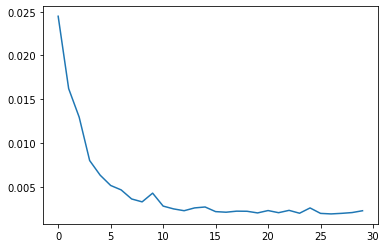

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
last_train_batch = scaled_train[-n_input:]

In [26]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [27]:
model.predict(last_train_batch)
     

1/1 [==============================] - 2s 2s/step


array([[0.9241248]], dtype=float32)

In [28]:
scaled_test[0]

array([1.02746529])

In [29]:

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 31ms/step


In [30]:
test_predictions

[array([0.9241248], dtype=float32),
 array([0.8550059], dtype=float32),
 array([0.79446197], dtype=float32),
 array([0.74459195], dtype=float32),
 array([0.70277786], dtype=float32),
 array([0.6661549], dtype=float32),
 array([0.6329399], dtype=float32),
 array([0.60252446], dtype=float32),
 array([0.57490134], dtype=float32),
 array([0.55022615], dtype=float32),
 array([0.52863544], dtype=float32),
 array([0.5101032], dtype=float32),
 array([0.49438235], dtype=float32),
 array([0.48111102], dtype=float32),
 array([0.46993837], dtype=float32),
 array([0.46057656], dtype=float32),
 array([0.4527982], dtype=float32),
 array([0.44641486], dtype=float32),
 array([0.4412574], dtype=float32),
 array([0.43716675], dtype=float32),
 array([0.43399236], dtype=float32),
 array([0.4315945], dtype=float32),
 array([0.4298467], dtype=float32),
 array([0.4286373], dtype=float32),
 array([0.42786932], dtype=float32),
 array([0.42745933], dtype=float32),
 array([0.4273353], dtype=float32),
 array([0.42

In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

C:\Users\Ankit Rawat\AppData\Local\Temp\ipykernel_10340\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [33]:
test.tail(15)

,Open,Predictions
Date,,
2023-03-08,86.769997,62.089030
2023-03-09,89.959999,62.092412
2023-03-10,91.900002,62.101583
2023-03-13,89.699997,62.115014
2023-03-14,91.169998,62.131420
2023-03-15,88.989998,62.149743
2023-03-16,89.400002,62.169122
2023-03-17,91.790001,62.188860
2023-03-20,90.629997,62.208423


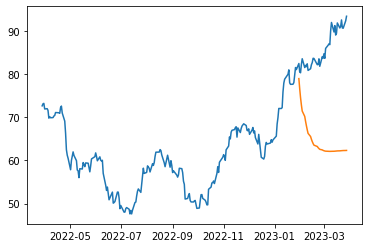

In [34]:
plt.plot(df1)
plt.plot(test.Predictions)

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Open'],test['Predictions']))
print(rmse)
     

22.25845044981282


In [36]:
len(df1)

251

In [37]:
future_input = df1[239:]
future_input.shape

(12, 1)

In [38]:
scaled_future = scaler.transform(future_input)

In [39]:
x_input= scaled_future.reshape((1, n_input))

In [40]:
x_input.shape

(1, 12)

In [41]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [42]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=12
i=0
while(i<30):
    
    if(len(temp_input)>12):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.2481034]
13
1 day input [1.28617017 1.22178923 1.23389769 1.30448043 1.27022257 1.28055914
 1.32515312 1.27022257 1.26845071 1.31895132 1.35025573 1.24810338]
1 day output [[1.1031806]]
2 day input [1.22178923 1.23389769 1.30448043 1.27022257 1.28055914 1.32515312
 1.27022257 1.26845071 1.31895132 1.35025573 1.24810338 1.10318065]
2 day output [[0.9763371]]
3 day input [1.23389769 1.30448043 1.27022257 1.28055914 1.32515312 1.27022257
 1.26845071 1.31895132 1.35025573 1.24810338 1.10318065 0.97633708]
3 day output [[0.88064176]]
4 day input [1.30448043 1.27022257 1.28055914 1.32515312 1.27022257 1.26845071
 1.31895132 1.35025573 1.24810338 1.10318065 0.97633708 0.88064176]
4 day output [[0.8093258]]
5 day input [1.27022257 1.28055914 1.32515312 1.27022257 1.26845071 1.31895132
 1.35025573 1.24810338 1.10318065 0.97633708 0.88064176 0.80932581]
5 day output [[0.75228375]]
6 day input [1.28055914 1.32515312 1.27022257 1.26845071 1.31895132 1.35025573
 1.24810338 1.10318065 0.97633708 

In [43]:
output = scaler.inverse_transform(lst_output)
output

array([[89.88102014],
       [84.97379814],
       [80.67875379],
       [77.43841907],
       [75.02359317],
       [73.09209452],
       [71.42116464],
       [69.92189065],
       [68.57783375],
       [67.39211215],
       [66.36746668],
       [65.50045214],
       [64.77838169],
       [64.18092024],
       [63.68713229],
       [63.27968291],
       [62.94558553],
       [62.67502532],
       [62.4598424 ],
       [62.29256918],
       [62.16614474],
       [62.07398851],
       [62.01015769],
       [61.96944414],
       [61.9473794 ],
       [61.94017922],
       [61.94463152],
       [61.95800963],
       [61.97799756],
       [62.00263963]])

In [44]:
df5 = pd.read_csv('GE.csv')
df5.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-29,72.615143,74.137390,72.615143,73.887589,73.568665,11009426
1,2022-03-30,73.083527,74.270103,72.833725,73.832947,73.514252,7216642
2,2022-03-31,73.185013,73.341141,71.405151,71.428574,71.120262,10537122
3,2022-04-01,71.896957,72.256050,71.124123,72.201408,71.889755,7226505
4,2022-04-04,71.959404,72.068695,70.960190,71.834503,71.524437,6583828


In [45]:
df5 = df5.Open

In [46]:
df5.head()

0    72.615143
1    73.083527
2    73.185013
3    71.896957
4    71.959404
Name: Open, dtype: float64

In [47]:
df5.shape

(251,)

In [48]:
arr_1d = output.flatten()


In [49]:
s = pd.Series(arr_1d)

In [50]:
s.head()

0    89.881020
1    84.973798
2    80.678754
3    77.438419
4    75.023593
dtype: float64

In [51]:
s.set_axis(pd.Index(range(252, 252+len(s))), inplace=True)
s.head()

252    89.881020
253    84.973798
254    80.678754
255    77.438419
256    75.023593
dtype: float64

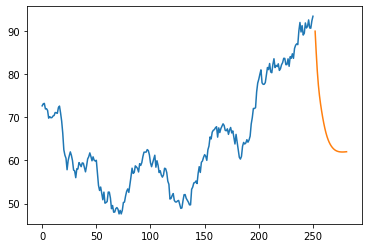

In [52]:

plt.plot(df5)
plt.plot(s)